In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

## <a name="C4">MODELISATION </a>

In [2]:
data = pd.read_csv('data01.csv')
print('Les dimensions du data training : ', data.shape)
data.head()

Les dimensions du data training :  (12300, 243)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,145360,0,126000.0,107820.0,5845.5,90000.0,0.016612,-8865,-595,-203.0,...,0,0,0,0,0,0,0,0,0,0
1,438982,1,157500.0,612000.0,23845.5,612000.0,0.009630,-11964,-822,-477.0,...,0,0,0,0,0,0,0,0,0,0
2,284875,0,247500.0,225000.0,11250.0,225000.0,0.010032,-11310,-3092,-5291.0,...,0,0,0,0,1,0,0,1,0,0
3,160582,2,121500.0,1260702.0,39712.5,1129500.0,0.025164,-13398,-4681,-2212.0,...,0,0,0,0,1,0,0,1,0,0
4,103634,0,292500.0,1125000.0,32895.0,1125000.0,0.035792,-17445,-3391,-8920.0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data = data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [4]:
#df001= data.sample(frac =0.04) 
#df001.shape

In [5]:
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [6]:
#scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##  <a name="C2"> Baseline avec Dummy regressor</a>

In [7]:
from sklearn.dummy import DummyRegressor
model = DummyRegressor(strategy="median")
model.fit(X_train, y_train)
DummyRegressor()

y_pred = model.predict(X_train)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
model.score(X_train, y_train)

-0.09184518877973735

In [9]:
model.score(X_test, y_test)

-0.08580508474576254

In [10]:
y_pred = model.predict(X_test)

In [11]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2832
           1       0.00      0.00      0.00       243

    accuracy                           0.92      3075
   macro avg       0.46      0.50      0.48      3075
weighted avg       0.85      0.92      0.88      3075



C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 ## Forêt aléatoire

In [12]:
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [13]:
from sklearn.ensemble import RandomForestClassifier
#implementation de FerestClassifier
mdl_fra = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
result = mdl_fra.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


In [14]:
y_pred = mdl_fra.predict(X_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [15]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [16]:
mdl_fra.score(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


1.0

In [17]:
mdl_fra.score(X_test, y_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9209756097560976

In [18]:
y_pred = mdl_fra.predict(X_test)
y_pred

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [19]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2832
           1       0.00      0.00      0.00       243

    accuracy                           0.92      3075
   macro avg       0.46      0.50      0.48      3075
weighted avg       0.85      0.92      0.88      3075



C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
#cross_val_score(RandomForestClassifier)

## XGBoots Classifier

In [21]:
from xgboost import XGBClassifier
import xgboost
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [22]:
y_pred = model.predict(X_test)

In [23]:
model.score(X_test, y_test)

0.9186991869918699

In [24]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2832
           1       0.41      0.07      0.11       243

    accuracy                           0.92      3075
   macro avg       0.67      0.53      0.54      3075
weighted avg       0.88      0.92      0.89      3075



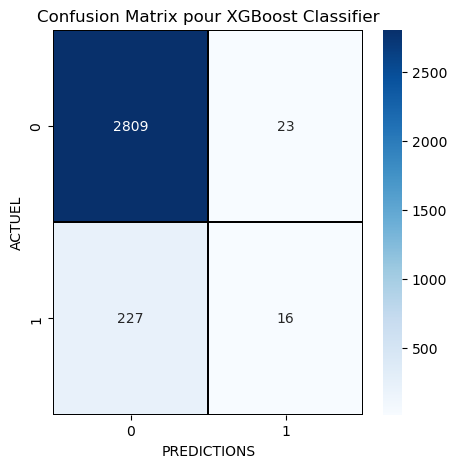

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

x_axis_labels = ["0", "1"]
y_axis_labels = ["0", "1"]

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f",
            ax=ax, cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUEL")
plt.title('Confusion Matrix pour XGBoost Classifier')
plt.show()

In [26]:
df=pd.read_csv('df_svm.csv') 
df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [27]:
X = df.drop('TARGET', axis = 1)
y = df['TARGET']

##  Support  Vecteurs Machines (SVM)

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
from sklearn.svm import SVC
mdl_svm = SVC(kernel='linear', C=1)

In [31]:
mdl_svm.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [32]:
y_pred = mdl_svm.predict(X_test)

In [33]:
mdl_svm.score(X_test, y_test)

0.8116883116883117

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       140
           1       0.11      0.14      0.12        14

    accuracy                           0.81       154
   macro avg       0.51      0.51      0.51       154
weighted avg       0.84      0.81      0.82       154



In [35]:
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

## Utilisation de l'algorithme SMOTE 

La methode SMOTE pour  pour résoudre le problème du déséquilibre des classes.

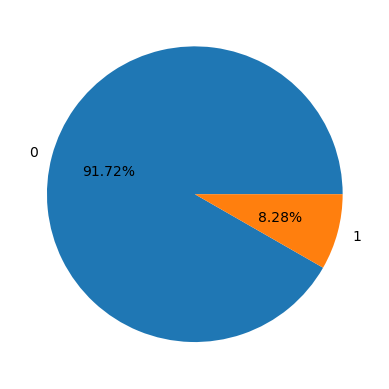

In [36]:
tar = (data['TARGET'].value_counts())/len(data)
plt.pie(tar,labels=tar.index,autopct='%.2f%%')# Diagramme en secteurs
plt.show()

In [37]:
X_train = X
y_train = y
sm = SMOTE()
X_smote, y_smote = sm.fit_resample(X_train, y_train)
data_sm = pd.concat([X_smote, y_smote], axis=1)

In [38]:
data_sm

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,145360,0,126000.000000,1.078200e+05,5845.500000,9.000000e+04,0.016612,-8865,-595,-203.000000,...,0,0,0,0,0,0,0,0,0,0
1,438982,1,157500.000000,6.120000e+05,23845.500000,6.120000e+05,0.009630,-11964,-822,-477.000000,...,0,0,0,0,0,0,0,0,0,0
2,284875,0,247500.000000,2.250000e+05,11250.000000,2.250000e+05,0.010032,-11310,-3092,-5291.000000,...,0,0,0,0,1,0,0,1,0,0
3,160582,2,121500.000000,1.260702e+06,39712.500000,1.129500e+06,0.025164,-13398,-4681,-2212.000000,...,0,0,0,0,1,0,0,1,0,0
4,103634,0,292500.000000,1.125000e+06,32895.000000,1.125000e+06,0.035792,-17445,-3391,-8920.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22557,389092,1,83805.226571,6.400800e+05,30073.392636,4.500000e+05,0.007396,-11307,-3054,-5232.294656,...,0,0,0,0,0,0,0,1,0,1
22558,180753,0,126275.419413,2.700000e+05,13472.044930,2.700000e+05,0.045248,-8419,-961,-8238.951677,...,0,0,0,0,0,0,0,1,0,1
22559,280627,0,77449.142944,1.209937e+05,6168.945297,9.943673e+04,0.013185,-20808,365243,-8836.937139,...,0,0,0,0,0,0,0,0,0,1
22560,353505,0,72472.999554,2.953406e+05,14644.354314,2.250000e+05,0.007763,-15501,-3010,-3269.810013,...,0,0,0,0,0,0,0,0,0,1


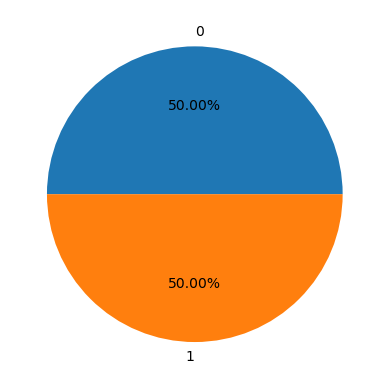

In [39]:
tar = (data_sm['TARGET'].value_counts())/len(data)
plt.pie(tar,labels=tar.index,autopct='%.2f%%')# Diagramme en secteurs
plt.show()

In [40]:
df_sm = data_sm.sample(frac =0.4) 
df_sm.shape

(9025, 243)

In [60]:
X = df_sm.drop('TARGET', axis = 1)
y = df_sm['TARGET']
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)


In [61]:
#scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##  <a name="C2"> Baseline avec Dummy regressor </a>

In [62]:
model = DummyRegressor(strategy="median")
model.fit(X_train, y_train)
DummyRegressor()

y_pred = model.predict(X_train)
print(y_pred)

[1. 1. 1. ... 1. 1. 1.]


In [63]:
model.score(X_train, y_train)

-0.992346187812776

In [64]:
model.score(X_test, y_test)

-0.9694589877835951

In [65]:
y_pred = model.predict(X_test)
print(y_pred)

[1. 1. 1. ... 1. 1. 1.]


In [66]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1111
           1       0.51      1.00      0.67      1146

    accuracy                           0.51      2257
   macro avg       0.25      0.50      0.34      2257
weighted avg       0.26      0.51      0.34      2257



C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Forêt aléatoire

In [67]:
#implementation de FerestClassifier
model = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

In [68]:
model.score(X_test, y_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9472751439964555

In [69]:
y_pred = model.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [70]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1111
           1       1.00      0.90      0.95      1146

    accuracy                           0.95      2257
   macro avg       0.95      0.95      0.95      2257
weighted avg       0.95      0.95      0.95      2257



## XGBoots Classifier

In [71]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [72]:
y_pred = model.predict(X_test)

In [73]:
model.score(X_train, y_train)

1.0

In [74]:
model.score(X_test, y_pred)

1.0

In [75]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1111
           1       0.99      0.91      0.95      1146

    accuracy                           0.95      2257
   macro avg       0.96      0.95      0.95      2257
weighted avg       0.96      0.95      0.95      2257



In [76]:
confusion_matrix(y_test, y_pred)

array([[1104,    7],
       [  99, 1047]], dtype=int64)

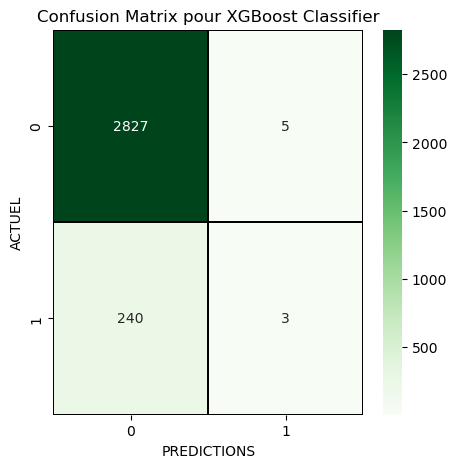

In [115]:
cm = confusion_matrix(y_test, y_pred)

x_axis_labels = ["0", "1"]
y_axis_labels = ["0", "1"]

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f",
            ax=ax, cmap="Greens", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUEL")
plt.title('Confusion Matrix pour XGBoost Classifier')
plt.show()

In [82]:
X = df_sm.drop('TARGET', axis = 1)
y = df_sm['TARGET']
y.shape

(9025,)

##  Support  Vecteurs Machines (SVM)

In [83]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [84]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [85]:
model = SVC(kernel='linear', C=1)

In [86]:
model.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [87]:
y_pred = model.predict(X_test)

In [88]:
model.score(X_test, y_test)

0.9570225963668587

In [89]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1125
           1       1.00      0.91      0.96      1132

    accuracy                           0.96      2257
   macro avg       0.96      0.96      0.96      2257
weighted avg       0.96      0.96      0.96      2257



In [90]:
from sklearn.model_selection import GridSearchCV

In [92]:
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

#scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [93]:
from sklearn.model_selection import StratifiedKFold
model = XGBClassifier()
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]

In [94]:
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

[2, 4, 6, 8]
Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [100]:

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.261771 using {'max_depth': 2, 'n_estimators': 50}
-0.261771 (0.008969) with: {'max_depth': 2, 'n_estimators': 50}
-0.263457 (0.010915) with: {'max_depth': 2, 'n_estimators': 100}
-0.267488 (0.011851) with: {'max_depth': 2, 'n_estimators': 150}
-0.269873 (0.013826) with: {'max_depth': 2, 'n_estimators': 200}
-0.268613 (0.010083) with: {'max_depth': 4, 'n_estimators': 50}
-0.279978 (0.012696) with: {'max_depth': 4, 'n_estimators': 100}
-0.292109 (0.014828) with: {'max_depth': 4, 'n_estimators': 150}
-0.303443 (0.016632) with: {'max_depth': 4, 'n_estimators': 200}
-0.284213 (0.017025) with: {'max_depth': 6, 'n_estimators': 50}
-0.313638 (0.023334) with: {'max_depth': 6, 'n_estimators': 100}
-0.343721 (0.029586) with: {'max_depth': 6, 'n_estimators': 150}
-0.372561 (0.034865) with: {'max_depth': 6, 'n_estimators': 200}
-0.304668 (0.017578) with: {'max_depth': 8, 'n_estimators': 50}
-0.355215 (0.025898) with: {'max_depth': 8, 'n_estimators': 100}
-0.392251 (0.030699) with: {'max_de

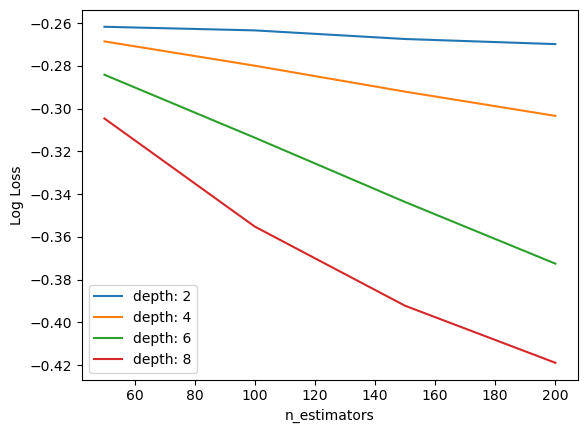

In [101]:
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
   plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_max_depth.png')

In [102]:
model = XGBClassifier(n_estimators = 50, max_depth = 2)
model.fit(X_train, y_train)

               

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [103]:
y_pred = model.predict(X_test)

In [104]:
model.score(X_train, y_train)

0.9176151761517615

In [105]:
model.score(X_test, y_pred)

1.0

In [106]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[2827,    5],
       [ 240,    3]], dtype=int64)

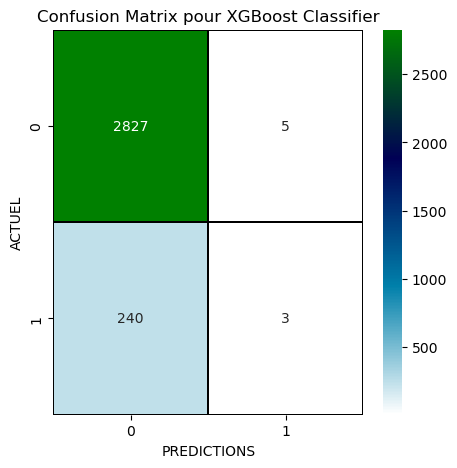

In [110]:
cm = confusion_matrix(y_test, y_pred)

x_axis_labels = ["0", "1"]
y_axis_labels = ["0", "1"]

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f",
            ax=ax, cmap="ocean_r", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUEL")
plt.title('Confusion Matrix pour XGBoost Classifier')
plt.show()

In [111]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2832
           1       0.38      0.01      0.02       243

    accuracy                           0.92      3075
   macro avg       0.65      0.51      0.49      3075
weighted avg       0.88      0.92      0.88      3075



In [112]:
import shap
explainer = shap.Explainer(model, X)
shap_values = explainer(X_test)

Les features les plus importants en moyenne pour ce modèle (F7, F29, F30)

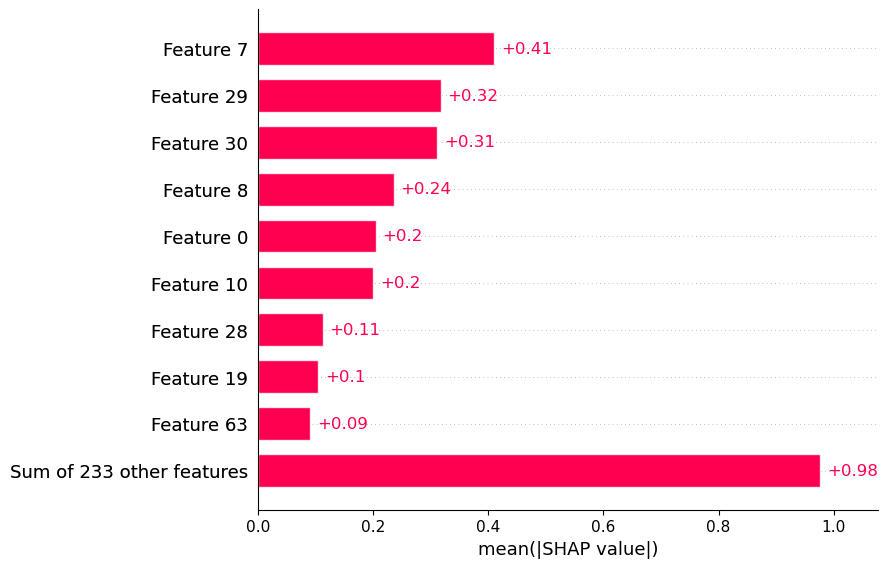

In [114]:
shap.plots.bar(shap_values)